In [ ]:
import os
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pwd

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the symptoms from the second file
with open('drive/My Drive/Projects/LSE-Symptomatology/Dataset/symptom_related_lexicon.txt', 'r') as file:
    symptoms_text = file.read()

In [ ]:
# Split the text by commas to get a list of symptoms and preprocess each symptom
all_symptoms_from_txt = [symptom.lower().strip() for symptom in symptoms_text.split(',')]
len(all_symptoms_from_txt)

31949

In [ ]:
# Remove symptoms named "PCOS" or "pcos"
all_symptoms_from_txt = [symptom for symptom in all_symptoms_from_txt if "pcos" not in symptom.lower()]

# Count the number of symptoms after removal
number_of_symptoms_after_removal = len(all_symptoms_from_txt)
number_of_symptoms_after_removal

30478

In [ ]:
# Remove symptoms named "none"
all_symptoms_from_txt = [symptom for symptom in all_symptoms_from_txt if "none" not in symptom.lower()]
# Count the number of symptoms after removal
number_of_symptoms_after_removal = len(all_symptoms_from_txt)
number_of_symptoms_after_removal

30370

In [ ]:
!pip install transformers torch sentence-transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 3.5 MB/s eta 0:00:00


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Load BERT model and tokenizer

with open('BERT-base.txt', 'r') as f:
    model_name = f.read().strip()
bert_model = BertModel.from_pretrained(model_name)
bert_tokenizer = BertTokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Function to get BERT-base embeddings
def get_bert_embedding(sentence, model, tokenizer, max_tokens):
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=max_tokens)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    max_pooled = outputs.last_hidden_state.max(dim=1).values
    return max_pooled.squeeze().cpu().numpy()

In [ ]:

# Ensure model uses GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
# Calculate max_tokens for BERT-base
max_tokens = max([len(bert_tokenizer.tokenize(symptom)) for symptom in all_symptoms_from_txt])

In [ ]:
max_tokens

31

In [ ]:
# Get BERT-base embeddings
symptoms_embeddings_bert_base = [get_bert_embedding(symptom, bert_model, bert_tokenizer, max_tokens) for symptom in all_symptoms_from_txt]

In [ ]:
with open('Phrase-BERT.txt', 'r') as f:
    model_name = f.read().strip()
phrase_bert_model = SentenceTransformer(model_name)
symptoms_embeddings_phrase_bert = phrase_bert_model.encode(all_symptoms_from_txt)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
# Get BioBERT embeddings and normalize
with open('BioBERT.txt', 'r') as f:
    model_name = f.read().strip()
biobert_model = SentenceTransformer(model_name)
symptoms_embeddings_biobert = biobert_model.encode(all_symptoms_from_txt)
normalized_embeddings_biobert = normalize(symptoms_embeddings_biobert, axis=1)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.32k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/433M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def calculate_silhouette_scores(data_matrix, min_clusters, max_clusters):
    cluster_results_km = pd.DataFrame(columns=['k', 'score'])
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        silhouette = silhouette_score(data_matrix, y)
        dic = {'k': [k], 'score': [silhouette]}
        cluster_results_km = pd.concat([cluster_results_km, pd.DataFrame(dic)])
    return cluster_results_km

In [ ]:
# Calculate silhouette scores for each embedding type
cluster_results_bert_base = calculate_silhouette_scores(np.vstack(symptoms_embeddings_bert_base), min_clusters=5, max_clusters=100)


  0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|          | 1/96 [00:38<1:01:14, 38.68s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▏         | 2/96 [01:20<1:03:10, 40.33s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 3/96 [02:02<1:03:54, 41.23s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` wi

In [ ]:
cluster_results_phrase_bert = calculate_silhouette_scores(np.vstack(symptoms_embeddings_phrase_bert), min_clusters=5, max_clusters=100)


  0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|          | 1/96 [00:39<1:03:06, 39.86s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▏         | 2/96 [01:13<56:38, 36.16s/it]  /usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 3/96 [01:46<54:09, 34.94s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will

In [ ]:
cluster_results_bio_bert = calculate_silhouette_scores(np.vstack(normalized_embeddings_biobert), min_clusters=5, max_clusters=100)

  0%|          | 0/96 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  1%|          | 1/96 [00:30<48:10, 30.43s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  2%|▏         | 2/96 [01:02<49:19, 31.49s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
  3%|▎         | 3/96 [01:34<48:53, 31.55s/it]/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will cha

In [ ]:
import pandas as pd
import os

def append_results(file_path, model_name, results_dict):
    # Prepare the new data as a DataFrame
    new_data = pd.DataFrame({
        'k': results_dict['k'],
        model_name + ' Score': results_dict['score']
    })

    # Check if the file exists
    if os.path.exists(file_path):
        # File exists, read the existing data
        existing_data = pd.read_csv(file_path)
        # Merge the new data with the existing data on 'k'
        updated_data = pd.merge(existing_data, new_data, on='k', how='outer')
    else:
        # File doesn't exist, the new data will be the initial content
        updated_data = new_data

    # Save the updated data back to the CSV
    updated_data.to_csv(file_path, index=False)
    print(f"Results appended to {file_path}")




In [ ]:
# File path in drive
file_path = "drive/My Drive/Data/cumulative_silhouette_scores.csv"




# For each run change the model will change
model_name = "Bio-BERT"
append_results(file_path, model_name, cluster_results_bio_bert)



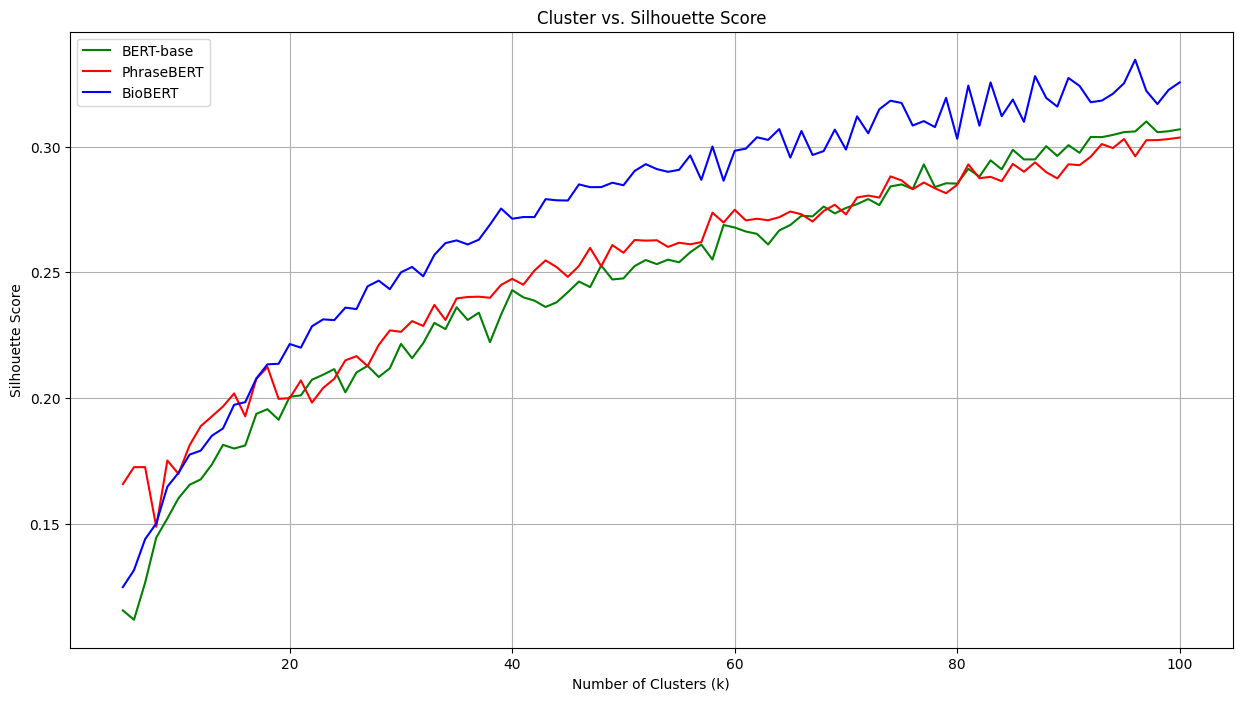

In [ ]:
import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(15, 8))
plt.plot(cluster_results_bert_base['k'], cluster_results_bert_base['score'], marker='', linestyle='-', color='g', label='BERT-base')
plt.plot(cluster_results_phrase_bert['k'], cluster_results_phrase_bert['score'], marker='', linestyle='-', color='r', label='PhraseBERT')
plt.plot(cluster_results_bio_bert['k'], cluster_results_bio_bert['score'], marker='', linestyle='-', color='b', label='BioBERT')
plt.title('Cluster vs. Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.legend()

# Save the figure as an SVG file
plt.savefig("silhouette_scores.svg", format='svg')

plt.show()
